# DS Ml Exercise

Import libraries

In [17]:
import pandas as pd
import joblib
import seaborn as sns
import json
import matplotlib.pyplot as plt
import unicodedata
import warnings
from html import unescape
from scipy.stats import pearsonr
from urllib import request
from sklearn import svm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import DataConversionWarning
warnings.filterwarnings("ignore")

Utility functions

In [24]:
def request_json_data(url):
  """
  Request url data
  :param url:
  :return:
  """
  with request.urlopen(url) as j:
    data = json.loads(j.read().decode())
  return data


def clean_text(text):
  """
  Deal with artifacts and remove accent (e.g á -> a)
  :param text:
  :return:
  """
  text = unescape(text)
  return ''.join(c for c in unicodedata.normalize('NFD', text)
                 if unicodedata.category(c) != 'Mn')


Lets start by loading and preparing all available data from the repository.

In [25]:
# Download all datasets from repo

# raw bechdel data
bechdel_data = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-03-09/raw_bechdel.csv", dtype=str)

# movies dataset
movies = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/bechdel/movies.csv", dtype=str)

# imdb data (also provided in the repo)
imdb = pd.DataFrame(request_json_data("https://raw.githubusercontent.com/brianckeegan/Bechdel/master/imdb_data.json"))


# Data canonicalization
bechdel_data['year'] = bechdel_data['year'].astype('int')
bechdel_data['rating'] = bechdel_data['rating'].astype('int')
movies['imdbid'] = movies['imdb'].apply(lambda x: x.split('tt')[1])  # get the proper imdb id format

# To get more data on the movies we join with movies dataset that includes 1794 movies
# Merge datasets to create a new dataset
movies_data = pd.merge(
  bechdel_data[['imdb_id', 'rating']], movies, how='right', left_on=['imdb_id'], right_on=['imdbid']
)

imdb = imdb.dropna(subset=['imdbID'])
imdb = imdb[imdb['imdbRating'] != 'N/A']
imdb = imdb[imdb['imdbVotes'] != 'N/A']
imdb['imdbid'] = imdb['imdbID'].apply(lambda x: x.split('tt')[1])  # get the proper imdb id format
imdb['imdbRating'] = imdb['imdbRating'].astype(float)
imdb['imdbVotes'] = imdb['imdbVotes'].apply(lambda x: float(x.replace(',', '')))

## Task 1

1. Average Bechdel Score Per Year.

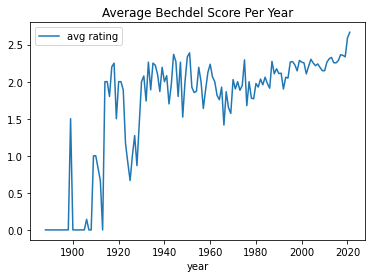

In [26]:
bechdel_data.loc[bechdel_data['year'] < 2022, ['year', 'rating']].groupby(['year']).mean().rename(
  columns={'rating': 'avg rating'}).plot()
plt.title('Average Bechdel Score Per Year')
plt.show()

2. ears where 50% of movies have a Bechdel score of 2 or higher.

In [27]:
l1st = []
for year in sorted(set(bechdel_data['year'].values.tolist())):
  num_over_two = len(bechdel_data[(bechdel_data['year'] == year) & (bechdel_data['rating'] >= 2)])
  num_all = len(bechdel_data[bechdel_data['year'] == year])
  if num_over_two / num_all == 0.5:
    l1st.append(year)
print(f"The years where 50% of movies have a Bechdel score of 2 or higher are: {', '.join(str(y) for y in l1st)}")

The years where 50% of movies have a Bechdel score of 2 or higher are: 1899, 1919, 1923, 1942


## Task 2

1.
Movies, Dataset quality assessment

Dataset data types and non-null rows
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1794 entries, 0 to 1793
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   imdb_id         1793 non-null   object 
 1   rating          1793 non-null   float64
 2   year            1794 non-null   object 
 3   imdb            1794 non-null   object 
 4   title           1794 non-null   object 
 5   test            1794 non-null   object 
 6   clean_test      1794 non-null   object 
 7   binary          1794 non-null   object 
 8   budget          1794 non-null   object 
 9   domgross        1777 non-null   object 
 10  intgross        1783 non-null   object 
 11  code            1794 non-null   object 
 12  budget_2013$    1794 non-null   object 
 13  domgross_2013$  1776 non-null   object 
 14  intgross_2013$  1783 non-null   object 
 15  period code     1615 non-null   object 
 16  decade code     1615 non-null   object 
 

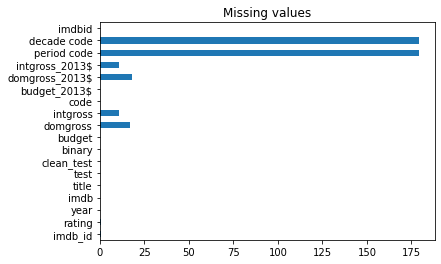

AxesSubplot(0.125,0.125;0.775x0.755)


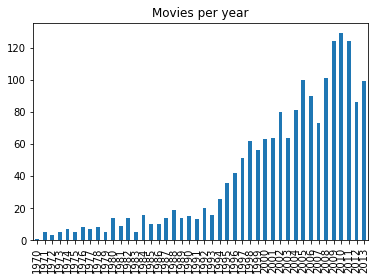

AxesSubplot(0.125,0.125;0.775x0.755)


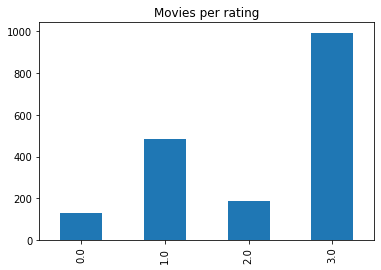

In [28]:
print("Dataset data types and non-null rows")
movies_data.info()

movies_data.isna().sum().plot.barh()
# Missing values per column
plt.title('Missing values')
plt.show()

# Number of movies per year
print(movies_data['year'].value_counts().sort_index().plot.bar())
plt.title('Movies per year')
plt.show()

# Number of movies per rating
print(movies_data['rating'].value_counts().sort_index().plot.bar())
plt.title('Movies per rating')
plt.show()

Search for duplicates in the dataset

In [29]:
# There are no duplicate rows in the dataset
print("Number of duplicate rows: ", len(movies_data[movies_data.duplicated()]))

# There are no duplicate imdb ids in the dataset
print("Number of imdb ids: ", len(movies_data[movies_data.duplicated(['imdb'], keep=False)]))

# Duplicate Titles
print("Number of duplicate movie titles: ", len(movies_data[movies_data.duplicated(['title'], keep=False)]))
print("\n")
print("Sample of Duplicates")
print(movies_data[movies_data.duplicated(['title'], keep=False)][['imdb_id', 'year', 'title', 'budget', 'budget_2013$']].sort_values('title')[:15])

Number of duplicate rows:  0
Number of imdb ids:  0
Number of duplicate movie titles:  51


Sample of Duplicates
      imdb_id  year                   title    budget budget_2013$
827   0398712  2005  Assault on Precinct 13  30000000     35790994
1760  0074156  1976  Assault on Precinct 13  30000000    122754817
12    1559547  2013     Beautiful Creatures  50000000     50000000
1218  0221889  2000     Beautiful Creatures  50000000     67645419
1773  0071222  1974         Black Christmas   9000000     42513535
741   0454082  2006         Black Christmas   9000000     10402167
15    1939659  2013                  Carrie  30000000     30000000
1084  0319970  2002                  Carrie  30000000     38855376
203   0816462  2011     Conan the Barbarian  20000000     20713816
1705  0082198  1982     Conan the Barbarian  20000000     48265360
945   0363547  2004        Dawn of the Dead  28000000     34529401
1746  0077402  1978        Dawn of the Dead  28000000     99979768
575   0489018  2

We see that there are duplicate movie titles with identical budget/gross and different normalized budget/gross. These are probably different movies, so what's up with the pre-normalization budget/gross etc ?

In [30]:
# Different movie with same budget
print(movies_data[movies_data['title'] == 'Beautiful Creatures'][
        ['title', 'year', 'budget', 'domgross', 'intgross', 'budget_2013$', 'domgross_2013$', 'intgross_2013$']
      ])

                    title  year    budget  domgross  intgross budget_2013$  \
12    Beautiful Creatures  2013  50000000  19452138  55940671     50000000   
1218  Beautiful Creatures  2000  50000000  19452138  55940671     67645419   

     domgross_2013$ intgross_2013$  
12         19452138       55940671  
1218       26316961       75682603  


2. Data cleaning

In [11]:
print(f" There are artifacts in the text (e.g. title: '{movies_data.iloc[0]['title']}')")

 There are artifacts in the text (e.g. title: '21 & Over')


In [15]:
# We deal with the artifacts and strip and accent todo: do more cleaning if there is any
movies_data['title'] = movies_data['title'].apply(lambda x: clean_text(x))
print(f"Clean title:`{movies_data.iloc[0]['title']}`")


Clean title:`21 & Over`


3. Correlate features

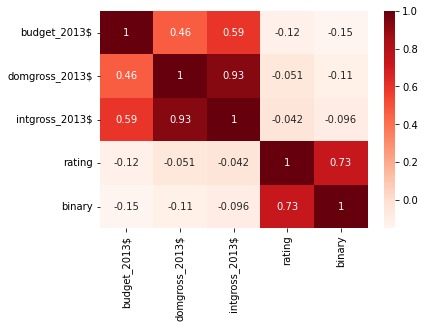

As we can see there is no strong correlation of any feature with the rating (Bechdel score) or the PASS or FAIL label. There is slight negative correlation of -0.15 between the budget of the movie and the PASS or FAIL label but its not significant. There is an even "worst" correlation of -0.12 between the budget of the movie and rating(score) also not significant. There is a strong correlation of 0.73 between the `rating` and the `binary`, but there both score labels therefore can not be considered as movies data features.


In [24]:
# prepare feature dataset
movies_features = movies_data[['year', 'budget_2013$', 'domgross_2013$', 'intgross_2013$', 'rating', 'binary']]
for col in ['budget_2013$', 'domgross_2013$', 'intgross_2013$', 'rating']:
  movies_features[col] = movies_features[col].astype(float)

# transform PAS/FAIL to binary labels
movies_features['binary'] = movies_features['binary'].apply(lambda x: 1 if x == "PASS" else 0)
movies_features = movies_features.dropna()

# calculate correlations
cor = movies_features.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
corr1, _ = pearsonr(movies_features['budget_2013$'], movies_features['binary'])
corr2, _ = pearsonr(movies_features['budget_2013$'], movies_features['rating'])
corr3, _ = pearsonr(movies_features['rating'], movies_features['binary'])

print('As we can see there is no strong correlation of any feature with the rating (Bechdel score) or the PASS or '
      'FAIL label. There is slight negative correlation of %.2f between the budget of the movie and the PASS or FAIL label but '
      'its not significant. There is an even "worst" negative correlation of %.2f between the budget of the movie and rating('
      'score) also not significant. There is a strong correlation of %.2f between the `rating` and the `binary`, '
      'but there both score labels therefore can not be considered as movies data features.'% (corr1, corr2, corr3))

Lets introduce more features


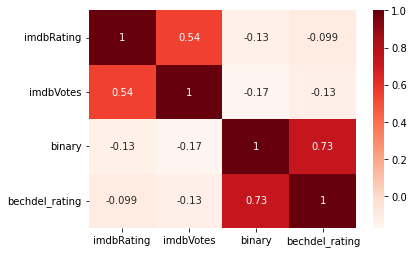

There is slight correlation of -0.17 between the imdb votes of the movie and the PASS or FAIL label but its not significant.There is an even "worst" negative correlation of -0.13 between the budget of the movie and rating(score) also not significant 


In [28]:
other_movies_features = pd.merge(
  imdb[['imdbid', 'imdbRating', 'imdbVotes']],
  movies_data[['imdbid', 'rating', 'binary']],
  how='right', on='imdbid'
)
other_movies_features['binary'] = other_movies_features['binary'].apply(lambda x: 1 if x == "PASS" else 0)
other_movies_features['bechdel_rating'] = other_movies_features['rating'].astype(float)
del other_movies_features['rating']
other_movies_features = other_movies_features.dropna()

cor = other_movies_features.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
corr4, _ = pearsonr(other_movies_features['imdbVotes'], other_movies_features['binary'])
corr5, _ = pearsonr(other_movies_features['imdbVotes'], other_movies_features['bechdel_rating'])
print('There is slight correlation of %.2f between the imdb votes of the movie and the PASS or FAIL label but its not significant.'
      'There is an even "worst" negative correlation of %.2f between the budget of the movie and rating('
      'score) also not significant. ' % (corr4, corr5))



## Task 3

Create dataset from train and testing including all possible features

In [ ]:
movies_features = pd.merge(
  imdb[['imdbid', 'imdbRating', 'imdbVotes']],
  movies_data[['imdbid', 'rating', 'budget_2013$', 'domgross_2013$', 'intgross_2013$']],
  how='right', on='imdbid'
)
movies_features = movies_features.dropna()
movies_features['rating'] = movies_features['rating'].astype(int)
movies_features['budget_2013$'] = movies_features['budget_2013$'].astype(float)
movies_features['domgross_2013$'] = movies_features['domgross_2013$'].astype(float)
movies_features['intgross_2013$'] = movies_features['intgross_2013$'].astype(float)

# Split features and labels
X = movies_features[['imdbRating', 'imdbVotes', 'budget_2013$', 'domgross_2013$', 'intgross_2013$']]
y = movies_features[['rating']]

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, stratify=y)
